# Scoring and Analyzing Oral health behavior

The following answers are considered positive oral health behavior:
- Frequency of daily tooth brushing (≥ twice)
- Duration of tooth brushing (≥ 2 min)
- Frequency of replacing toothbrush (≤ 3 months)
- Frequency of visiting the dentist (regularly)

The following options are considered correct:

##### 1. Frequency of daily tooth brushing.
b. 2

c. More than 2


##### 2. Duration of tooth brushing.
b. 2 to 3 minutes

c. More than 3 minutes

##### 3. Frequency of replacing tooth brush.
a. Every month

b. Every two months

c. Every three months

##### 4. Frequency of visiting dentist.
a. Once a year

b. Twice a year

c. More than 2 times a year

In [1906]:
import pandas as pd
import numpy as np

In [1907]:
df = pd.read_csv("oral-health-uofg-cleaned.csv")
df.isna().sum()

RecordID                                                                      0
Timestamp                                                                     0
Are you a student at University of Gezira?                                    0
Age                                                                           0
Gender                                                                        0
Faculty                                                                       0
Academic level                                                                0
Causes of dental caries                                                       0
Causes of bleeding during tooth brushing:                                     0
Influence of dental plaque:                                                   0
Measures that prevent oral diseases:                                          0
Systemic diseases that may be related to oral diseases:                       0
Which is more important for oral health:

In [1908]:
df_behavior = df[
    [
        "RecordID",
        "Gender",
        "Faculty",
        "Academic level",
        "Frequency of daily tooth brushing.",
        "Duration of tooth brushing.",
        "Frequency of replacing tooth brush.",
        "Frequency of visiting dentist.",
        "Method of tooth brushing:",
        "Oral hygiene methods besides tooth brushing:",
    ]
].copy()

df_behavior.rename(
    columns={
        "Frequency of daily tooth brushing.": "Q1",
        "Duration of tooth brushing.": "Q2",
        "Frequency of replacing tooth brush.": "Q3",
        "Frequency of visiting dentist.": "Q4",
        "Method of tooth brushing:": "Q5",
        "Oral hygiene methods besides tooth brushing:": "Q6",
    },
    inplace=True,
)

In [1909]:
df_behavior.fillna({"Q6": "None"}, inplace=True)
df_behavior.isna().sum()  # Cleaning is done, no NaN values left

RecordID          0
Gender            0
Faculty           0
Academic level    0
Q1                0
Q2                0
Q3                0
Q4                0
Q5                0
Q6                0
dtype: int64

I'll be calculating if every unit answered correctly or not to be able to apply chi-square test later

In [1910]:
df_behavior["Q1_score"] = df_behavior["Q1"].apply(
    lambda x: 1 if x in ["2", "More than 2"] else 0
)
df_behavior["Q2_score"] = df_behavior["Q2"].apply(
    lambda x: 1 if x in ["2 to 3 minutes", "More than 3 minutes"] else 0
)
df_behavior["Q3_score"] = df_behavior["Q3"].apply(
    lambda x: 1 if x in ["Every month", "Every two months", "Every three months"] else 0
)
df_behavior["Q4_score"] = df_behavior["Q4"].apply(
    lambda x: 1 if x in ["Once a year", "Twice a year"] else 0
)

In [1911]:
def calculate_score(df, group, question, answers):
    """
    df: DataFrame containing the behavior data.
    group: The column to group by (e.g., 'Faculty').
    question: The question column to calculate the score for.
    answers: List of acceptable answers for the question.
    Calculate the score for a given question in the behavior DataFrame.
    """
    return (
        df[df[question].isin(answers)].groupby(group)[question].count()
        / df.groupby(group)[question].count()
    )

In [1912]:
df_behavior["behavior_score"] = df_behavior[df_behavior.columns[10:]].sum(axis=1) / 4
df_behavior.head()

,RecordID,Gender,Faculty,Academic level,Q1,Q2,Q3,Q4,Q5,Q6,Q1_score,Q2_score,Q3_score,Q4_score,behavior_score
0,0,Male,Medicine,Fourth year,1,2 to 3 minutes,Every three months,When I have a dental problem/oral disease,Irregular,Mouthwash,0,1,1,0,0.50
1,1,Male,Medicine,Fifth year,2,More than 3 minutes,Every three months,Twice a year,Horizontal scrub,Mouthwash,1,1,1,1,1.00
2,2,Male,Dentistry,Fourth year,2,2 to 3 minutes,Every three months,Twice a year,Modified pass technique,Toothpick,1,1,1,1,1.00
3,3,Male,Medicine,Fifth year,1,More than 3 minutes,Every three months,Once a year,Vertical scrub,Mouthwash,0,1,1,1,0.75
4,4,Male,Medicine,Third year,1,2 to 3 minutes,Until it can't be used,When I have a dental problem/oral disease,Horizontal scrub,Sugar-free chewing gum,0,1,0,0,0.25


In [1913]:
df_behavior_faculty_score = pd.DataFrame(
    index=df_behavior["Faculty"].unique(),
    columns=["Q1_score", "Q2_score", "Q3_score", "Q4_score"],
)

In [1914]:
df_behavior_faculty_score["Q1_score"] = calculate_score(
    df_behavior, "Faculty", "Q1", ["2", "More than 2"]
)
df_behavior_faculty_score["Q2_score"] = calculate_score(
    df_behavior, "Faculty", "Q2", ["2 to 3 minutes", "More than 3 minutes"]
)
df_behavior_faculty_score["Q3_score"] = calculate_score(
    df_behavior,
    "Faculty",
    "Q3",
    ["Every month", "Every two months", "Every three months"],
)
df_behavior_faculty_score["Q4_score"] = calculate_score(
    df_behavior, "Faculty", "Q4", ["Once a year", "Twice a year"]
)

df_behavior_faculty_score

,Q1_score,Q2_score,Q3_score,Q4_score
Medicine,0.744868,0.906158,0.785924,0.275660
Dentistry,0.900000,0.916667,0.916667,0.683333


<Axes: >

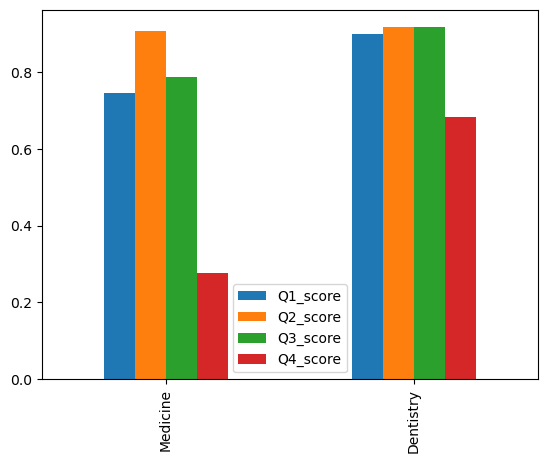

In [1915]:
df_behavior_faculty_score.plot(kind="bar")

In [1916]:
index = pd.MultiIndex.from_product(
    [df_behavior["Academic level"].unique(), df_behavior["Faculty"].unique()],
    names=["Academic level", "Faculty"],
)
df_behavior_level_faculty_score = pd.DataFrame(
    index=index, columns=["Q1_score", "Q2_score", "Q3_score", "Q4_score"]
)

In [1917]:
df_behavior_level_faculty_score["Q1_score"] = calculate_score(
    df_behavior, ["Academic level", "Faculty"], "Q1", ["2", "More than 2"]
).reindex(index)
df_behavior_level_faculty_score["Q2_score"] = calculate_score(
    df_behavior,
    ["Academic level", "Faculty"],
    "Q2",
    ["2 to 3 minutes", "More than 3 minutes"],
).reindex(index)
df_behavior_level_faculty_score["Q3_score"] = calculate_score(
    df_behavior,
    ["Academic level", "Faculty"],
    "Q3",
    ["Every month", "Every two months", "Every three months"],
).reindex(index)
df_behavior_level_faculty_score["Q4_score"] = calculate_score(
    df_behavior, ["Academic level", "Faculty"], "Q4", ["Once a year", "Twice a year"]
).reindex(index)
df_behavior_level_faculty_score

Q1_score  Q2_score  Q3_score  Q4_score
Academic level Faculty                                          
Fourth year    Medicine   0.738462  0.923077  0.784615  0.384615
               Dentistry  0.857143  0.952381  0.857143  0.476190
Fifth year     Medicine   0.710843  0.903614  0.831325  0.337349
               Dentistry  0.888889  0.888889  1.000000  0.888889
Third year     Medicine   0.772277  0.900990  0.732673  0.198020
               Dentistry  1.000000  0.857143  1.000000  0.714286
Second year    Medicine   0.826087  0.934783  0.847826  0.282609
               Dentistry  0.933333  0.933333  0.933333  0.800000
First year     Medicine   0.673913  0.869565  0.760870  0.173913
               Dentistry  0.875000  0.875000  0.875000  0.750000

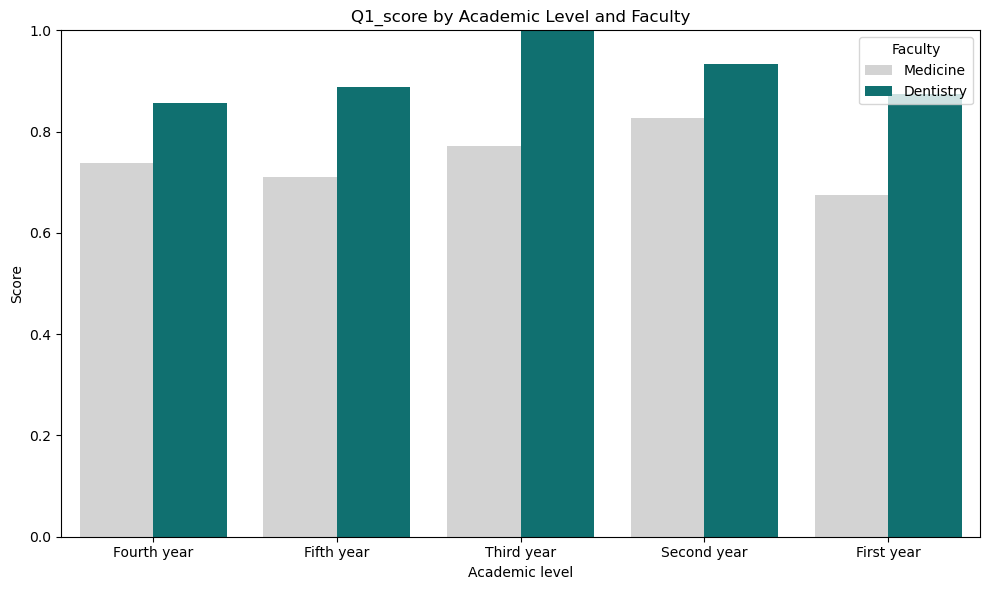

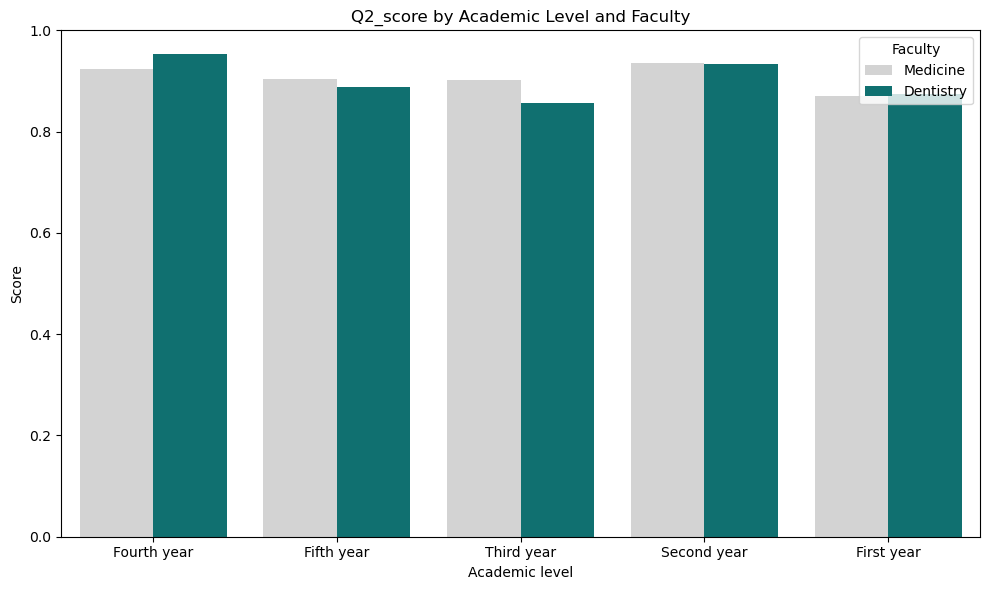

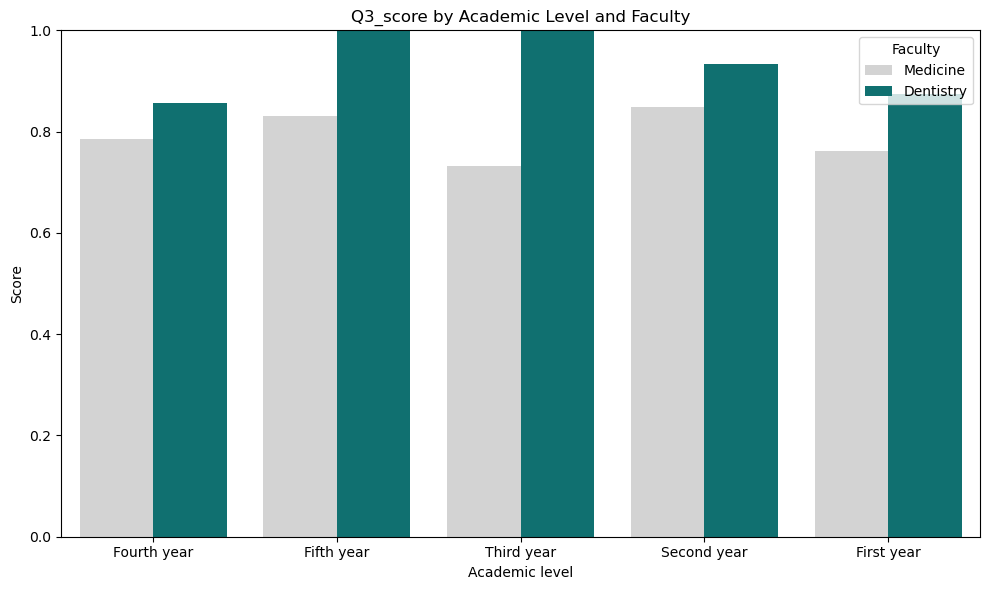

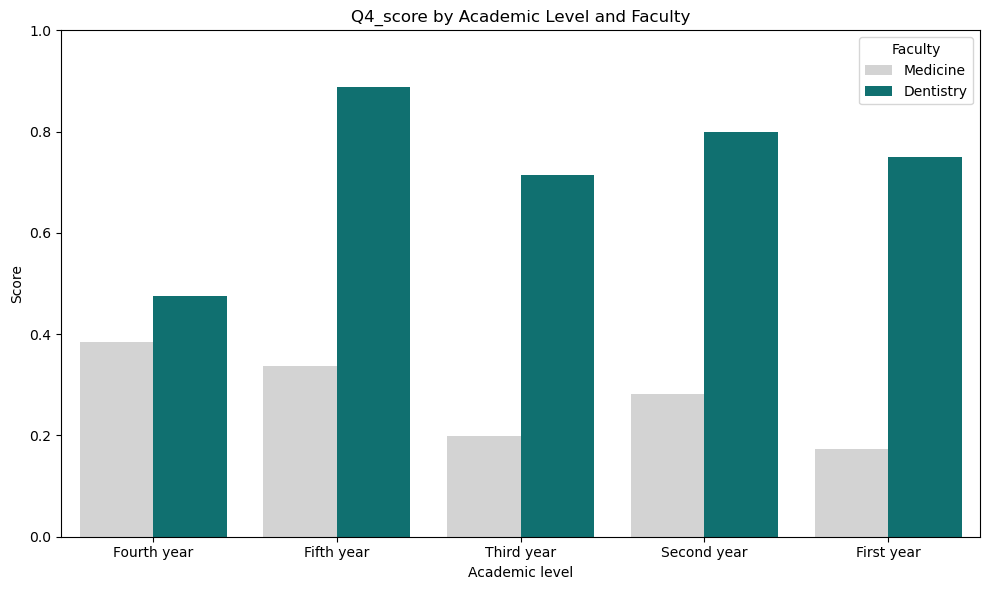

In [1918]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reset index
df_plot = df_behavior_level_faculty_score.reset_index()

palette = {"Dentistry": "teal", "Medicine": "lightgray"}

for question in df_behavior_level_faculty_score.columns:
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df_plot, x="Academic level", y=question, hue="Faculty", palette=palette
    )
    plt.title(f"{question} by Academic Level and Faculty")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

In [1919]:
df_behavior.groupby(["Academic level", "Faculty"])[
    "behavior_score"
].mean().reset_index()

,Academic level,Faculty,behavior_score
0,Fifth year,Dentistry,0.916667
1,Fifth year,Medicine,0.695783
2,First year,Dentistry,0.843750
3,First year,Medicine,0.619565
4,Fourth year,Dentistry,0.785714
5,Fourth year,Medicine,0.707692
6,Second year,Dentistry,0.900000
7,Second year,Medicine,0.722826
8,Third year,Dentistry,0.892857
9,Third year,Medicine,0.650990


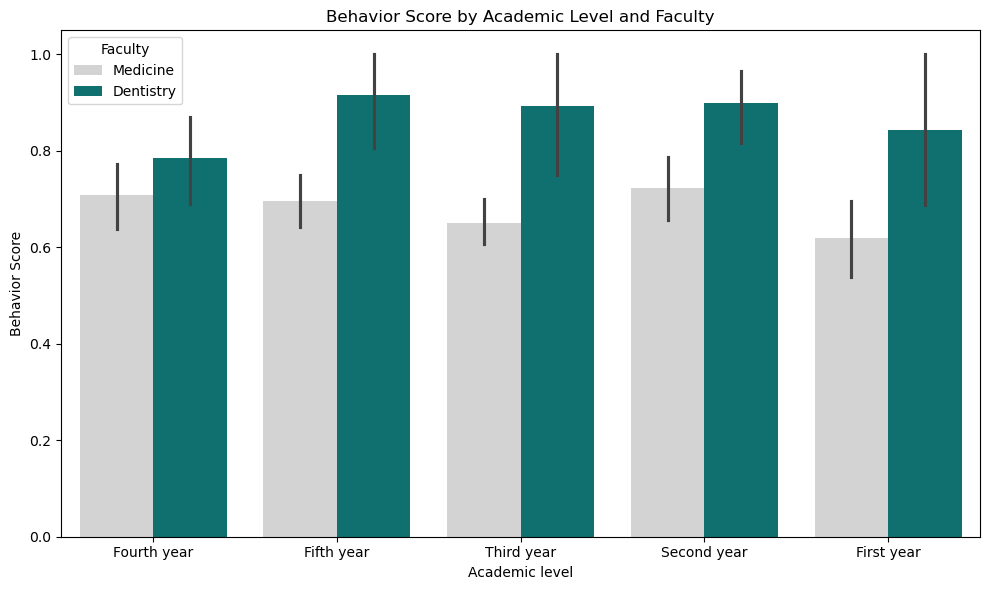

In [1920]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_behavior,
    x="Academic level",
    y="behavior_score",
    hue="Faculty",
    palette=palette,
)

plt.title("Behavior Score by Academic Level and Faculty")
plt.ylabel("Behavior Score")
plt.tight_layout()
plt.show()

In [1921]:
group_faculty = df_behavior.groupby("Faculty")["behavior_score"].mean()
group_faculty

Faculty
Dentistry    0.854167
Medicine     0.678152
Name: behavior_score, dtype: float64

<Axes: xlabel='Faculty'>

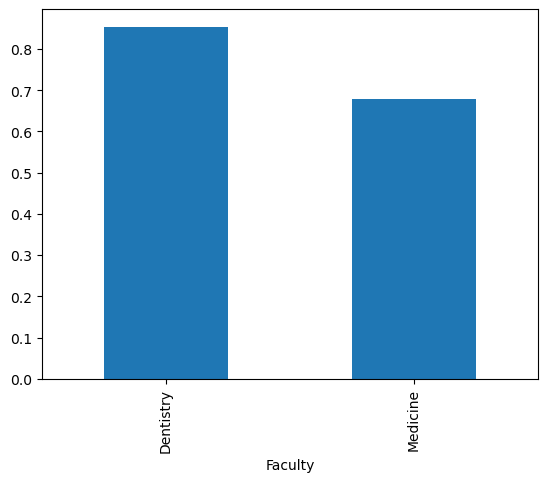

In [1922]:
group_faculty.plot(kind="bar")

## Descriptive Analytics for Score of Behavior of Healthcare students
mean = 0.70

mode = 0.75

median = 0.75

std = 0.25

variance = 0.065


In [1923]:
df_behavior["behavior_score"].describe()

count    401.000000
mean       0.704489
std        0.255475
min        0.000000
25%        0.500000
50%        0.750000
75%        1.000000
max        1.000000
Name: behavior_score, dtype: float64

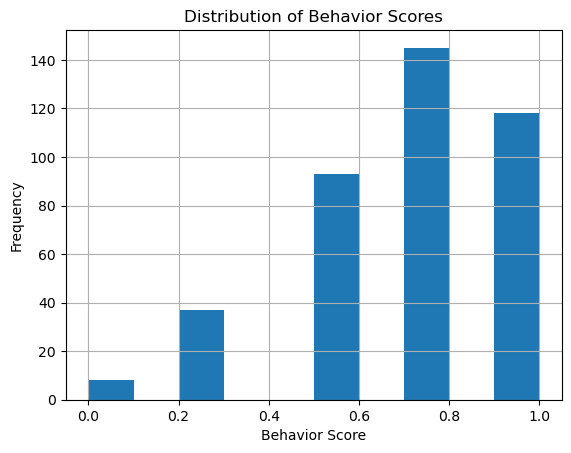

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [1924]:
df_behavior["behavior_score"].describe()
df_behavior["behavior_score"].hist(bins=10)
plt.title("Distribution of Behavior Scores")
plt.xlabel("Behavior Score")
plt.ylabel("Frequency")
plt.show()
plt.figure(figsize=(10, 6))

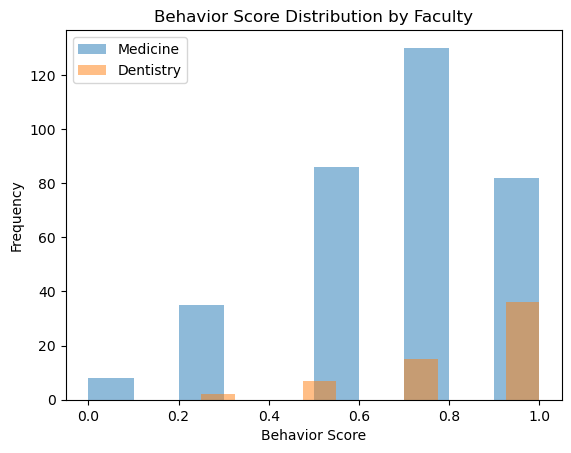

In [1925]:
faculties = df["Faculty"].unique()

for faculty in faculties:
    subset = df_behavior[df_behavior["Faculty"] == faculty]
    plt.hist(subset["behavior_score"], bins=10, alpha=0.5, label=faculty)

plt.legend()
plt.xlabel("Behavior Score")
plt.ylabel("Frequency")
plt.title("Behavior Score Distribution by Faculty")
plt.show()

In [1926]:
np.median(df_behavior["behavior_score"])

0.75

In [1927]:
import statistics

statistics.mode(df_behavior["behavior_score"])

0.75

In [1928]:
np.var(df_behavior["behavior_score"], ddof=1)  # Using ddof=1 for sample variance

0.06526730049875307

{'whiskers': [<matplotlib.lines.Line2D at 0x176a9d2b0>,
 'caps': [<matplotlib.lines.Line2D at 0x176a9d850>,
 'boxes': [<matplotlib.lines.Line2D at 0x176a9d010>],
 'medians': [<matplotlib.lines.Line2D at 0x176a9ddc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x176a9e060>],
 'means': []}

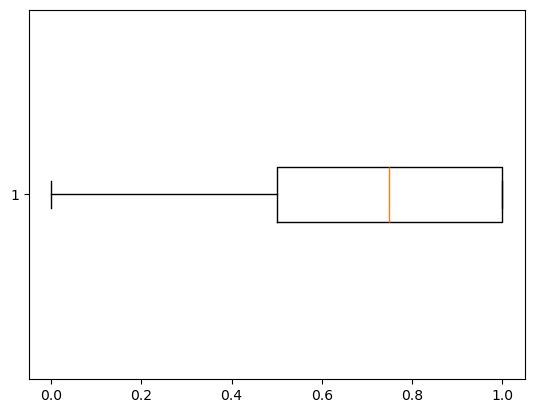

In [1929]:
plt.boxplot(df_behavior["behavior_score"], vert=False)

Since the whiskers extend until 0, there's no outliers

## Inferential Statistics of Behavior among healthcare students
1. Hypothesis building
2. Population and Sample
3. Hypothesis testing
4. p-value
5. Significance
6. Errors

#### H₀ (Null): There is no significant difference in oral health behaviors between dental and medical students at University of Gezira.

To measure the p-value and verify the significance of the differences seen above, calculations will be divided into two parts:
1. Checking if proportions differ between groups regarding every question comparing the number of students who answered correctly vs incorrectly for each question. Chi-square test was used before for this purpose, but since groups are imbalanced (refer to cleaning.ipynb to check exact number of each group) I will experiment with using Fisher's Exact Test.
2. To check the significance of difference between total score (sum of correct answers) between groups, t-test will be used 

In [1930]:
from scipy.stats import fisher_exact


def compute_pvalues_fisher(df_long, group_col, value_col, pvals):
    """
    Args:
    df_long (_type_): a wide format DataFrame with columns for group, value, and question
    group_col (_type_): a list of columns that are used to group the data.
    value_col (_type_): The value column that contains the numerical data to be analyzed.
    question_col (_type_): The column that contains the question options.
    """
    if isinstance(group_col, str):
        group_col = [group_col]

    # group by the first grouping column (e.g., academic_level)
    if len(group_col) != 2:
        contingency_table = pd.crosstab(df_long[group_col[0]], df_long[value_col])
        if contingency_table.shape != (2, 2):
            pvals[value_col] = float("nan")
        else:
            oddsratio, p = fisher_exact(contingency_table)
            pvals[value_col] = round(p, 2)
    else:
        for first_group_val, subgroup in df_long.groupby(group_col[0]):
            # create contingency table with rows = second grouping column (e.g., faculty)
            # columns = value_col (0/1)
            contingency_table = pd.crosstab(subgroup[group_col[1]], subgroup[value_col])

            # If the table is degenerate (e.g., no variation), skip or assign p=nan
            if contingency_table.shape != (2, 2):
                pvals[(value_col, first_group_val)] = float("nan")
            else:
                oddsratio, p = fisher_exact(contingency_table)
                pvals[(value_col, first_group_val)] = round(p, 2)

In [1931]:
pvals = {}

In [1932]:
pvals = {}
questions = ["Q1_score", "Q2_score", "Q3_score", "Q4_score"]
for question in questions:
    compute_pvalues_fisher(
        df_long=df_behavior,
        group_col=["Academic level", "Faculty"],
        value_col=question,
        pvals=pvals,
    )

In [1933]:
def final_table(table_academic_level, pvals):
    # Assuming table_academic_level is your pivot table with MultiIndex columns
    # And pvals is your dictionary: keys=(question, academic_level), values=p-value

    # Step 1: Create empty DataFrame for p-values
    pval_df = pd.DataFrame(index=table_academic_level.index)

    # Get all unique academic levels in the order they appear in the columns
    academic_levels = table_academic_level.columns.get_level_values(0).unique()

    for level in academic_levels:
        # Build a Series of p-values for all questions for this academic level
        pvals_for_level = {
            question: pvals.get((question, level), np.nan)
            for question in table_academic_level.index
        }
        pval_series = pd.Series(pvals_for_level, index=table_academic_level.index)

        # Add to pval_df with MultiIndex column
        pval_df[(level, "p-value")] = pval_series

    # Concatenate pval_df to original pivot table
    combined = pd.concat([table_academic_level, pval_df], axis=1)

    # Reorder columns to put 'p-value' after each academic level's faculties
    new_cols = []

    for level in academic_levels:
        # Get all columns for this level excluding p-value
        level_faculties = [
            col for col in table_academic_level.columns if col[0] == level
        ]
        new_cols.extend(level_faculties)
        # Append the p-value column for this level
        new_cols.append((level, "p-value"))

    # Select columns in new order
    final_table = combined[new_cols]
    return final_table

In [1934]:
df_behavior_pivot = df_behavior.pivot_table(
    index=[],
    columns=["Academic level", "Faculty"],
    values=["Q1_score", "Q2_score", "Q3_score", "Q4_score"],
    aggfunc="mean",
)

In [1935]:
table = final_table(df_behavior_pivot, pvals)
table

Fifth year                   First year                    \
          Dentistry  Medicine p-value  Dentistry  Medicine p-value   
Q1_score   0.888889  0.710843    0.44      0.875  0.673913    0.41   
Q2_score   0.888889  0.903614    1.00      0.875  0.869565    1.00   
Q3_score   1.000000  0.831325    0.35      0.875  0.760870    0.67   
Q4_score   0.888889  0.337349    0.00      0.750  0.173913    0.00   

         Fourth year                   Second year                    \
           Dentistry  Medicine p-value   Dentistry  Medicine p-value   
Q1_score    0.857143  0.738462    0.38    0.933333  0.826087    0.43   
Q2_score    0.952381  0.923077    1.00    0.933333  0.934783    1.00   
Q3_score    0.857143  0.784615    0.55    0.933333  0.847826    0.67   
Q4_score    0.476190  0.384615    0.61    0.800000  0.282609    0.00   

         Third year                    
          Dentistry  Medicine p-value  
Q1_score   1.000000  0.772277    0.34  
Q2_score   0.857143  0.900990    0.54  
Q3_score   1.000000  0.732673    0.19  
Q4_score   0.714286  0.198020    0.01

In [1936]:
pvals = {}
questions = ["Q1_score", "Q2_score", "Q3_score", "Q4_score"]
for question in questions:
    compute_pvalues_fisher(
        df_long=df_behavior, group_col=["Faculty"], value_col=question, pvals=pvals
    )

In [1937]:
df_behavior_faculty_pivot = df_behavior.pivot_table(
    index=[],
    columns=["Faculty"],
    values=["Q1_score", "Q2_score", "Q3_score", "Q4_score"],
    aggfunc="mean",
)

In [1938]:
p_vals = pd.Series(pvals, index=df_behavior_faculty_pivot.index)
table_with_p_faculty = pd.concat(
    [df_behavior_faculty_pivot, p_vals.rename("p-value")], axis=1
)
table_with_p_faculty.columns.name = None
table_with_p_faculty

,Dentistry,Medicine,p-value
Q1_score,0.900000,0.744868,0.01
Q2_score,0.916667,0.906158,1.00
Q3_score,0.916667,0.785924,0.02
Q4_score,0.683333,0.275660,0.00


Using the fisher's test in determining significance seems like a wise option. The p-value is meaningful in this context and truly identifies the differences when necessary.

It seems like the null hypothesis is highly possible to be rejected. Final call will be left to the final calculation of the behavior_score. Before moving forward, I will use one hot encoding to figure out Q5 and Q6 and also apply Fisher's exact test on it.

In [1939]:
df_behavior_wide = df_behavior[
    ["Gender", "Faculty", "Academic level", "Q5", "Q6"]
].copy()

In [1940]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

mlb = MultiLabelBinarizer()

# Wrap each entry as a list, so mlb works properly
q5_lists = df_behavior_wide["Q5"].apply(lambda x: [x] if pd.notnull(x) else [])

one_hot = pd.DataFrame(
    mlb.fit_transform(q5_lists), columns=mlb.classes_, index=df_behavior_wide.index
)

df_join = df_behavior_wide.join(one_hot)
df_join

,Gender,Faculty,Academic level,Q5,Q6,Fones technique,Horizontal scrub,Irregular,Modified pass technique,Vertical scrub
0,Male,Medicine,Fourth year,Irregular,Mouthwash,0,0,1,0,0
1,Male,Medicine,Fifth year,Horizontal scrub,Mouthwash,0,1,0,0,0
2,Male,Dentistry,Fourth year,Modified pass technique,Toothpick,0,0,0,1,0
3,Male,Medicine,Fifth year,Vertical scrub,Mouthwash,0,0,0,0,1
4,Male,Medicine,Third year,Horizontal scrub,Sugar-free chewing gum,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
396,Male,Medicine,Fourth year,Modified pass technique,Mouthwash,0,0,0,1,0
397,Male,Medicine,Fourth year,Modified pass technique,Mouthwash,0,0,0,1,0
398,Female,Medicine,Fifth year,Modified pass technique,"Dental floss, Mouthwash, Sugar-free chewing gum",0,0,0,1,0
399,Male,Medicine,Fourth year,Irregular,"Dental floss, Mouthwash, Sugar-free chewing gu...",0,0,1,0,0


In [1941]:
pvals = {}
for col in one_hot.columns:
    compute_pvalues_fisher(
        df_long=df_join,
        group_col=["Academic level", "Faculty"],
        value_col=col,
        pvals=pvals,
    )
pvals

{('Fones technique', 'Fifth year'): 1.0,
 ('Fones technique', 'First year'): 0.57,
 ('Fones technique', 'Fourth year'): 1.0,
 ('Fones technique', 'Second year'): 1.0,
 ('Fones technique', 'Third year'): 0.29,
 ('Horizontal scrub', 'Fifth year'): 0.35,
 ('Horizontal scrub', 'First year'): 0.33,
 ('Horizontal scrub', 'Fourth year'): 0.44,
 ('Horizontal scrub', 'Second year'): 0.1,
 ('Horizontal scrub', 'Third year'): 1.0,
 ('Irregular', 'Fifth year'): 0.59,
 ('Irregular', 'First year'): 0.42,
 ('Irregular', 'Fourth year'): 0.34,
 ('Irregular', 'Second year'): 0.03,
 ('Irregular', 'Third year'): 0.67,
 ('Modified pass technique', 'Fifth year'): 0.0,
 ('Modified pass technique', 'First year'): 0.41,
 ('Modified pass technique', 'Fourth year'): 0.08,
 ('Modified pass technique', 'Second year'): 1.0,
 ('Modified pass technique', 'Third year'): 1.0,
 ('Vertical scrub', 'Fifth year'): 0.05,
 ('Vertical scrub', 'First year'): 0.34,
 ('Vertical scrub', 'Fourth year'): 1.0,
 ('Vertical scrub', 'S

In [1942]:
df_behavior_pivot = df_join.pivot_table(
    index=[],
    columns=["Academic level", "Faculty"],
    values=one_hot.columns,
    aggfunc="mean",
)
df_behavior_pivot

Academic level          Fifth year           First year           Fourth year  \
Faculty                  Dentistry  Medicine  Dentistry  Medicine   Dentistry   
Fones technique                0.0  0.036145      0.125  0.086957    0.000000   
Horizontal scrub               0.0  0.192771      0.000  0.195652    0.047619   
Irregular                      0.0  0.120482      0.125  0.304348    0.095238   
Modified pass technique        1.0  0.313253      0.375  0.239130    0.619048   
Vertical scrub                 0.0  0.337349      0.375  0.173913    0.238095   

Academic level                    Second year           Third year            
Faculty                  Medicine   Dentistry  Medicine  Dentistry  Medicine  
Fones technique          0.015385    0.000000  0.043478   0.142857  0.039604  
Horizontal scrub         0.138462    0.333333  0.108696   0.142857  0.198020  
Irregular                0.215385    0.000000  0.282609   0.142857  0.277228  
Modified pass technique  0.384615    0.266667  0.239130   0.142857  0.227723  
Vertical scrub           0.246154    0.400000  0.326087   0.428571  0.257426

In [1943]:
table = final_table(df_behavior_pivot, pvals)
table

Fifth year                   First year            \
                         Dentistry  Medicine p-value  Dentistry  Medicine   
Fones technique                0.0  0.036145    1.00      0.125  0.086957   
Horizontal scrub               0.0  0.192771    0.35      0.000  0.195652   
Irregular                      0.0  0.120482    0.59      0.125  0.304348   
Modified pass technique        1.0  0.313253    0.00      0.375  0.239130   
Vertical scrub                 0.0  0.337349    0.05      0.375  0.173913   

                                Fourth year                   Second year  \
                        p-value   Dentistry  Medicine p-value   Dentistry   
Fones technique            0.57    0.000000  0.015385    1.00    0.000000   
Horizontal scrub           0.33    0.047619  0.138462    0.44    0.333333   
Irregular                  0.42    0.095238  0.215385    0.34    0.000000   
Modified pass technique    0.41    0.619048  0.384615    0.08    0.266667   
Vertical scrub             0.34    0.238095  0.246154    1.00    0.400000   

                                          Third year                    
                         Medicine p-value  Dentistry  Medicine p-value  
Fones technique          0.043478    1.00   0.142857  0.039604    0.29  
Horizontal scrub         0.108696    0.10   0.142857  0.198020    1.00  
Irregular                0.282609    0.03   0.142857  0.277228    0.67  
Modified pass technique  0.239130    1.00   0.142857  0.227723    1.00  
Vertical scrub           0.326087    0.76   0.428571  0.257426    0.38

In [1944]:
df_behavior_faculty_pivot = df_join.pivot_table(
    index=[], columns=["Faculty"], values=one_hot.columns, aggfunc="mean"
)

df_behavior_faculty_pivot

Faculty,Dentistry,Medicine
Fones technique,0.033333,0.041056
Horizontal scrub,0.116667,0.173021
Irregular,0.066667,0.231672
Modified pass technique,0.500000,0.281525
Vertical scrub,0.283333,0.272727


In [1945]:
pvals = {}
for col in one_hot.columns:
    compute_pvalues_fisher(
        df_long=df_join, group_col=["Faculty"], value_col=col, pvals=pvals
    )

In [1946]:
p_vals = pd.Series(pvals, index=df_behavior_faculty_pivot.index)
table_with_p_faculty = pd.concat(
    [df_behavior_faculty_pivot, p_vals.rename("p-value")], axis=1
)
table_with_p_faculty.columns.name = None
table_with_p_faculty

,Dentistry,Medicine,p-value
Fones technique,0.033333,0.041056,1.00
Horizontal scrub,0.116667,0.173021,0.35
Irregular,0.066667,0.231672,0.00
Modified pass technique,0.500000,0.281525,0.00
Vertical scrub,0.283333,0.272727,0.88


Most of dentistry students brush their teeth more than twice a day, while most medicine students brush once or twice a day. Dentistry students also brush for longer durations and replace their toothbrushes more frequently. The difference in behavior scores between faculties is statistically significant for most of the questions, with dentistry students scoring higher on average.

In [1947]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

mlb = MultiLabelBinarizer()

df_behavior_wide["Q6_split"] = df_behavior_wide["Q6"].str.split(", ")

one_hot = pd.DataFrame(
    mlb.fit_transform(df_behavior_wide["Q6_split"]),
    columns=mlb.classes_,
    index=df_behavior_wide.index,
)
df_behavior_wide.drop(columns=["Q6_split"], inplace=True)
df_join = df_behavior_wide.join(one_hot)

In [1948]:
pvals = {}
for col in one_hot.columns:
    compute_pvalues_fisher(
        df_long=df_join,
        group_col=["Academic level", "Faculty"],
        value_col=col,
        pvals=pvals,
    )

In [1949]:
df_behavior_pivot = df_join.pivot_table(
    index=[],
    columns=["Academic level", "Faculty"],
    values=one_hot.columns,
    aggfunc="mean",
)
df_behavior_pivot

Academic level         Fifth year           First year           Fourth year  \
Faculty                 Dentistry  Medicine  Dentistry  Medicine   Dentistry   
Dental floss             1.000000  0.180723      0.750  0.282609    0.809524   
Mouthwash                0.777778  0.542169      0.750  0.326087    0.571429   
None                     0.000000  0.240964      0.125  0.369565    0.047619   
Sugar-free chewing gum   0.666667  0.349398      0.375  0.239130    0.380952   
Toothpick                0.333333  0.301205      0.250  0.217391    0.142857   

Academic level                   Second year           Third year            
Faculty                 Medicine   Dentistry  Medicine  Dentistry  Medicine  
Dental floss            0.307692    0.933333  0.326087   0.428571  0.237624  
Mouthwash               0.661538    0.733333  0.565217   0.428571  0.574257  
None                    0.184615    0.000000  0.239130   0.285714  0.247525  
Sugar-free chewing gum  0.323077    0.600000  0.304348   0.428571  0.306931  
Toothpick               0.323077    0.333333  0.282609   0.142857  0.227723

In [1950]:
table = final_table(df_behavior_pivot, pvals)
table

Fifth year                   First year            \
                        Dentistry  Medicine p-value  Dentistry  Medicine   
Dental floss             1.000000  0.180723    0.00      0.750  0.282609   
Mouthwash                0.777778  0.542169    0.29      0.750  0.326087   
None                     0.000000  0.240964    0.20      0.125  0.369565   
Sugar-free chewing gum   0.666667  0.349398    0.08      0.375  0.239130   
Toothpick                0.333333  0.301205    1.00      0.250  0.217391   

                               Fourth year                   Second year  \
                       p-value   Dentistry  Medicine p-value   Dentistry   
Dental floss              0.02    0.809524  0.307692    0.00    0.933333   
Mouthwash                 0.04    0.571429  0.661538    0.60    0.733333   
None                      0.24    0.047619  0.184615    0.17    0.000000   
Sugar-free chewing gum    0.41    0.380952  0.323077    0.79    0.600000   
Toothpick                 1.00    0.142857  0.323077    0.16    0.333333   

                                         Third year                    
                        Medicine p-value  Dentistry  Medicine p-value  
Dental floss            0.326087    0.00   0.428571  0.237624    0.36  
Mouthwash               0.565217    0.36   0.428571  0.574257    0.47  
None                    0.239130    0.05   0.285714  0.247525    1.00  
Sugar-free chewing gum  0.304348    0.06   0.428571  0.306931    0.68  
Toothpick               0.282609    0.75   0.142857  0.227723    1.00

In [1951]:
df_behavior_faculty_pivot = df_join.pivot_table(
    index=[], columns=["Faculty"], values=one_hot.columns, aggfunc="mean"
)

df_behavior_faculty_pivot

Faculty,Dentistry,Medicine
Dental floss,0.816667,0.255132
Mouthwash,0.650000,0.548387
None,0.066667,0.249267
Sugar-free chewing gum,0.483333,0.310850
Toothpick,0.233333,0.269795


In [1952]:
pvals = {}
for col in one_hot.columns:
    compute_pvalues_fisher(
        df_long=df_join, group_col=["Faculty"], value_col=col, pvals=pvals
    )

In [1953]:
p_vals = pd.Series(pvals, index=df_behavior_faculty_pivot.index)
table_with_p_faculty = pd.concat(
    [df_behavior_faculty_pivot, p_vals.rename("p-value")], axis=1
)
table_with_p_faculty.columns.name = None
table_with_p_faculty

,Dentistry,Medicine,p-value
Dental floss,0.816667,0.255132,0.00
Mouthwash,0.650000,0.548387,0.16
None,0.066667,0.249267,0.00
Sugar-free chewing gum,0.483333,0.310850,0.01
Toothpick,0.233333,0.269795,0.64


### To check the significance of difference between total score (sum of correct answers) between groups, t-test will be used 

In [1954]:
import scipy.stats as stats

pvals = {}
for level, subgroup in df_behavior.groupby("Academic level"):
    # Create two groups based on the second grouping column
    groups = [
        group["behavior_score"].values for name, group in subgroup.groupby("Faculty")
    ]
    _, p = stats.ttest_ind(groups[0], groups[1], equal_var=False)
    pvals[level] = round(p, 2)


table = df_behavior.pivot_table(
    values="behavior_score",
    index=[],
    columns=["Academic level", "Faculty"],
    aggfunc=np.mean,
)

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_66304/3669423980.py:13: FutureWarning: The provided callable <function mean at 0x108c0cc20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table = df_behavior.pivot_table(


In [1955]:
pval_df = pd.DataFrame(index=table.index)

# For each academic level, create a p-value column with NaNs (or p-value repeated)
for level in pvals:
    # Create a MultiIndex column with (level, 'p-value')
    col = pd.MultiIndex.from_tuples([(level, "p-value")])
    # Create a Series with the p-value repeated for all rows (likely just one row)
    pval_series = pd.Series([pvals[level]] * len(table), index=table.index)
    # Assign to DataFrame
    pval_df[col] = pval_series

# Now concatenate along columns
combined = pd.concat([table, pval_df], axis=1)

new_cols = []

for level in sorted(table.columns.levels[0]):  # iterate academic levels in order
    # faculty columns for this level
    faculties = [col for col in table.columns if col[0] == level]
    new_cols.extend(faculties)
    # add p-value column for this level
    new_cols.append((level, "p-value"))

combined = combined[new_cols]

combined

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_66304/3682480166.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pval_df[col] = pval_series
/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_66304/3682480166.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pval_df[col] = pval_series
/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_66304/3682480166.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

Fifth year                   First year                    \
                Dentistry  Medicine p-value  Dentistry  Medicine p-value   
behavior_score   0.916667  0.695783    0.01    0.84375  0.619565    0.03   

               Fourth year                   Second year                    \
                 Dentistry  Medicine p-value   Dentistry  Medicine p-value   
behavior_score    0.785714  0.707692    0.22         0.9  0.722826     0.0   

               Third year                   
                Dentistry Medicine p-value  
behavior_score   0.892857  0.65099    0.02

This shows significant difference in behavior score between dental and medical studnets.

In [1956]:
groups = [
    group["behavior_score"].values for name, group in df_behavior.groupby("Faculty")
]
_, p = stats.ttest_ind(groups[0], groups[1], equal_var=False)
pivot_scores = df_behavior.pivot_table(
    index=[],  # no index, we want a single row
    columns="Faculty",
    values="behavior_score",
    aggfunc=np.mean,
).reset_index(drop=True)
pivot_scores["p-value"] = p
pivot_scores

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_66304/1360836182.py:3: FutureWarning: The provided callable <function mean at 0x108c0cc20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_scores = df_behavior.pivot_table(


Faculty,Dentistry,Medicine,p-value
0,0.854167,0.678152,7.334261e-08


It's evident that Dental students have better behavior scores compared to medical studnets.

In [1957]:
groups = [
    group["behavior_score"].values for name, group in df_behavior.groupby("Gender")
]
_, p = stats.ttest_ind(groups[0], groups[1], equal_var=False)
pivot_scores = df_behavior.pivot_table(
    index=[], columns="Gender", values="behavior_score", aggfunc=np.mean
).reset_index(drop=True)
pivot_scores["p-value"] = p
pivot_scores

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_66304/3150867269.py:3: FutureWarning: The provided callable <function mean at 0x108c0cc20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_scores = df_behavior.pivot_table(


Gender,Female,Male,p-value
0,0.723039,0.644737,0.013411


There's a significant difference in behavior score between dental and medical students, with dental students scoring higher on average. The p-value indicates that this difference is statistically significant, suggesting that the faculty (Dentistry vs Medicine) has a meaningful impact on behavior scores.
There's also a significant difference in behavior scores between males and females.

# Scoring and Analyzing Oral health Status

In [1958]:
df_status = df[
    [
        "RecordID",
        "Gender",
        "Faculty",
        "Academic level",
        "What oral health problem(s) do you have (you can choose more than one):",
    ]
].copy()

df_status.rename(
    columns={
        "What oral health problem(s) do you have (you can choose more than one):": "Q1"
    },
    inplace=True,
)
df_status

,RecordID,Gender,Faculty,Academic level,Q1
0,0,Male,Medicine,Fourth year,Abnormal growth of last molar in the left side...
1,1,Male,Medicine,Fifth year,Dental caries
2,2,Male,Dentistry,Fourth year,No problem
3,3,Male,Medicine,Fifth year,Toothache
4,4,Male,Medicine,Third year,Toothache
...,...,...,...,...,...
396,403,Male,Medicine,Fourth year,Tooth hypersensitivity
397,404,Male,Medicine,Fourth year,Oral ulcers
398,405,Female,Medicine,Fifth year,"Dental caries, Gingival bleeding, Oral ulcers,..."
399,406,Male,Medicine,Fourth year,Dental caries


In [1959]:
oral_health_problems = [
    "Bad breath",
    "Bruxism",
    "Dental caries",
    "Gingival bleeding",
    "Oral ulcers",
    "Toothache",
    "Tooth discolorationTooth hypersensitivity",
    "No problem",
]
df_status.loc[~df_status["Q1"].isin(oral_health_problems), "Q1"] = "Others"
df_status

,RecordID,Gender,Faculty,Academic level,Q1
0,0,Male,Medicine,Fourth year,Others
1,1,Male,Medicine,Fifth year,Dental caries
2,2,Male,Dentistry,Fourth year,No problem
3,3,Male,Medicine,Fifth year,Toothache
4,4,Male,Medicine,Third year,Toothache
...,...,...,...,...,...
396,403,Male,Medicine,Fourth year,Others
397,404,Male,Medicine,Fourth year,Oral ulcers
398,405,Female,Medicine,Fifth year,Others
399,406,Male,Medicine,Fourth year,Dental caries


In [1960]:
mlb = MultiLabelBinarizer()

df_status["Q1_split"] = df_status["Q1"].str.split(", ")

one_hot = pd.DataFrame(
    mlb.fit_transform(df_status["Q1_split"]),
    columns=mlb.classes_,
    index=df_behavior_wide.index,
)
df_status.drop(columns=["Q1_split"], inplace=True)
df_join = df_status.join(one_hot)

In [1961]:
pvals = {}
for col in one_hot.columns:
    compute_pvalues_fisher(
        df_long=df_join,
        group_col=["Academic level", "Faculty"],
        value_col=col,
        pvals=pvals,
    )

In [1962]:
df_behavior_pivot = df_join.pivot_table(
    index=[],
    columns=["Academic level", "Faculty"],
    values=one_hot.columns,
    aggfunc="mean",
)

In [1963]:
table = final_table(df_behavior_pivot, pvals)
table

Fifth year                   First year                    \
                   Dentistry  Medicine p-value  Dentistry  Medicine p-value   
Bad breath          0.000000  0.000000     NaN      0.000  0.021739    1.00   
Bruxism             0.000000  0.000000     NaN      0.000  0.000000     NaN   
Dental caries       0.222222  0.192771    1.00      0.250  0.065217    0.15   
Gingival bleeding   0.000000  0.012048    1.00      0.000  0.021739    1.00   
No problem          0.000000  0.253012    0.11      0.375  0.304348    0.70   
Oral ulcers         0.000000  0.012048    1.00      0.000  0.000000     NaN   
Others              0.777778  0.518072    0.17      0.375  0.500000    0.71   
Toothache           0.000000  0.012048    1.00      0.000  0.086957    1.00   

                  Fourth year                   Second year                    \
                    Dentistry  Medicine p-value   Dentistry  Medicine p-value   
Bad breath           0.047619  0.000000    0.24    0.066667  0.000000    0.25   
Bruxism              0.047619  0.000000    0.24    0.000000  0.000000     NaN   
Dental caries        0.190476  0.169231    1.00    0.200000  0.065217    0.15   
Gingival bleeding    0.047619  0.000000    0.24    0.000000  0.021739    1.00   
No problem           0.380952  0.261538    0.41    0.533333  0.239130    0.05   
Oral ulcers          0.000000  0.015385    1.00    0.000000  0.021739    1.00   
Others               0.285714  0.538462    0.05    0.200000  0.608696    0.01   
Toothache            0.000000  0.015385    1.00    0.000000  0.043478    1.00   

                  Third year                    
                   Dentistry  Medicine p-value  
Bad breath          0.000000  0.000000     NaN  
Bruxism             0.000000  0.009901    1.00  
Dental caries       0.142857  0.138614    1.00  
Gingival bleeding   0.142857  0.019802    0.18  
No problem          0.285714  0.158416    0.33  
Oral ulcers         0.000000  0.019802    1.00  
Others              0.428571  0.603960    0.44  
Toothache           0.000000  0.049505    1.00

In [1964]:
df_behavior_faculty_pivot = df_join.pivot_table(
    index=[], columns=["Faculty"], values=one_hot.columns, aggfunc="mean"
)

In [1965]:
pvals = {}
for col in one_hot.columns:
    compute_pvalues_fisher(
        df_long=df_join, group_col=["Faculty"], value_col=col, pvals=pvals
    )

In [1966]:
p_vals = pd.Series(pvals, index=df_behavior_faculty_pivot.index)
table_with_p_faculty = pd.concat(
    [df_behavior_faculty_pivot, p_vals.rename("p-value")], axis=1
)
table_with_p_faculty.columns.name = None
table_with_p_faculty

,Dentistry,Medicine,p-value
Bad breath,0.033333,0.002933,0.06
Bruxism,0.016667,0.002933,0.28
Dental caries,0.200000,0.137830,0.23
Gingival bleeding,0.033333,0.014663,0.28
No problem,0.350000,0.231672,0.07
Oral ulcers,0.000000,0.014663,1.00
Others,0.366667,0.557185,0.01
Toothache,0.000000,0.038123,0.23


Dental students had lower prevalence rate of oral health problems than their medical counterparts in some aspect